Code to replicate the results reported for study 1.

In [1]:
%matplotlib inline
#! switch_R 3.3
# Ensure R version plays well with rpy2
%load_ext rpy2.ipython

In [2]:
from __future__ import division
import numpy as np
np.random.seed(0)
import random
import statsmodels.stats.api as sms
from pyspan.ratings_task.analysis import *

/Users/sabinasloman/Box/LoP/pyspan/pyspan/config.py:19: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/Users/sabinasloman/.pyenv/versions/2.7.17/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/Users/sabinasloman/.pyenv/versions/2.7.17/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/Users/sabinasloman/.pyenv/versions/2.7.17/envs/lop_env/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/sabinasloman/.pyenv/versions/2.7.17/envs/lop_env/lib/python2.7/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  

In [3]:
pos_ixs = filter(lambda ix: antonyms.loc[(ix+79,"valence")] == "POS", 
                 np.arange(20))
neg_ixs = filter(lambda ix: antonyms.loc[(ix+79,"valence")] == "NEG", 
                 np.arange(20))
# Reorder neg_ixs so each column matches its partner antonyms
neg_ixs = [90, 91, 92, 94, 95, 98, 79, 83, 86, 87]
neg_ixs = [ix-79 for ix in neg_ixs]

# Demographics

In [4]:
dat = deepcopy(minidf[map(str, range(79,99))].values)
# ddat__ contains data from Democrats
ddat__ = dat[minidf.party == "Democrat",:]
# rdat__ contains data from Republicans
rdat__ = dat[minidf.party == "Republican",:]

In [5]:
dat.shape, ddat__.shape, rdat__.shape

((147, 20), (61, 20), (38, 20))

In [6]:
np.mean(minidf.loc[(minidf.party == "Democrat","age")]), \
stats.sem(minidf.loc[(minidf.party == "Democrat","age")])

(35.9344262295082, 1.3906142945108189)

In [7]:
minidf.loc[(minidf.party == "Democrat","gender")].value_counts()

F    35
M    26
Name: gender, dtype: int64

In [8]:
np.mean(minidf.loc[(minidf.party == "Republican","age")]), \
stats.sem(minidf.loc[(minidf.party == "Republican","age")])

(40.10526315789474, 1.5736040455896694)

In [9]:
minidf.loc[(minidf.party == "Republican","gender")].value_counts()

M    21
F    17
Name: gender, dtype: int64

# Hypothesis tests of the valence bias

In [10]:
# Dem responses on the positive stimuli
ddat_pos = ddat__[:,pos_ixs]
# Repub responses on the positive stimuli
rdat_pos = rdat__[:,pos_ixs]
# Dem responses on the negative stimuli
ddat_neg = ddat__[:,neg_ixs]
# Repub responses on the negative stimuli
rdat_neg = rdat__[:,neg_ixs]

Calculate means. Add 1 because the data are coded on a 0--5 scale, but described in the paper on a 1--6 scale.

In [11]:
d_pos_mu = np.mean(ddat_pos[~np.isnan(ddat_pos)]) + 1
r_pos_mu = np.mean(rdat_pos[~np.isnan(rdat_pos)]) + 1
d_neg_mu = np.mean(ddat_neg[~np.isnan(ddat_neg)]) + 1
r_neg_mu = np.mean(rdat_neg[~np.isnan(rdat_neg)]) + 1

In [12]:
d_pos_mu, r_pos_mu, d_neg_mu, r_neg_mu

(3.2459016393442623, 3.8153034300791555, 3.7701149425287355, 2.876315789473684)

Bootstrap standard errors around the means of judgments on the valenced words.

In [13]:
dmu_pos, rmu_pos, dmu_neg, rmu_neg = [], [], [], []
nd = ddat__.shape[0]
nr = rdat__.shape[0]
for _ in range(100):
    ddat___ = ddat__[[random.choice(range(nd)) for _ in range(nd)],:]
    rdat___ = rdat__[[random.choice(range(nr)) for _ in range(nr)],:]
    dpos = ddat___[:,pos_ixs][~np.isnan(ddat___[:,pos_ixs])]
    rpos = rdat___[:,pos_ixs][~np.isnan(rdat___[:,pos_ixs])]
    dneg = ddat___[:,neg_ixs][~np.isnan(ddat___[:,neg_ixs])]
    rneg = rdat___[:,neg_ixs][~np.isnan(rdat___[:,neg_ixs])]
    dmu_pos.append(np.mean(dpos))
    rmu_pos.append(np.mean(rpos))
    dmu_neg.append(np.mean(dneg))
    rmu_neg.append(np.mean(rneg))

In [14]:
se_dp = np.std(dmu_pos)
se_rp = np.std(rmu_pos)
se_dn = np.std(dmu_neg)
se_rn = np.std(rmu_neg)

In [15]:
se_dp, se_rp, se_dn, se_rn

(0.0624615442025375,
 0.08218207018092878,
 0.06926788109166554,
 0.11661517792719647)

A series of $t$-tests (with errors clustered at the participant level). Referenced by the number of stars in the Figure 1a.

Hypothesis: Republicans' judgments on the positive words are higher than Democrats' judgments on the positive words.

In [16]:
%%R -i ddat_pos,rdat_pos
# https://www.researchgate.net/publication/251965897_Cluster-robust_standard_errors_using_R
clx <- function(fm, dfcw, cluster){
          library(sandwich)
          library(lmtest)
          M <- length(unique(cluster))
          N <- length(cluster)
          dfc <- (M/(M-1))*((N-1)/(N-fm$rank))
          u  <- apply(estfun(fm),2,
                      function(x) tapply(x, cluster, sum))
          vcovCL <- dfc*sandwich(fm, meat=crossprod(u)/N)*dfcw
          coeftest(fm, vcovCL) }
y <- c(t(ddat_pos), t(rdat_pos))
nd <- dim(ddat_pos)[1]
nr <- dim(rdat_pos)[1]
kd <- dim(ddat_pos)[2]
kr <- dim(rdat_pos)[2]
stopifnot(kd == kr)
clusters <- c(rep(1:nd, each = kd), rep((nd+1):(nd+nr), each = kr))
clusters <- clusters[which(!is.na(y))]
groups <- c(rep(0, nd*kd), rep(1, nr*kr))
fit <- lm(y ~ groups)
clx(fit, 1, clusters)

/Users/sabinasloman/.pyenv/versions/2.7.17/envs/lop_env/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: zoo

  warnings.warn(x, RRuntimeWarning)
/Users/sabinasloman/.pyenv/versions/2.7.17/envs/lop_env/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: 
Attaching package: ‘zoo’


  warnings.warn(x, RRuntimeWarning)
/Users/sabinasloman/.pyenv/versions/2.7.17/envs/lop_env/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


  warnings.warn(x, RRuntimeWarning)



t test of coefficients:

            Estimate Std. Error t value  Pr(>|t|)    
(Intercept) 2.245902   0.060731 36.9813 < 2.2e-16 ***
groups      0.569402   0.114339  4.9799 7.505e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1



Hypothesis: Republicans' judgments on the negative words are lower than Democrats' judgments on the negative words.

In [17]:
%%R -i ddat_neg,rdat_neg
y <- c(t(ddat_neg), t(rdat_neg))
nd <- dim(ddat_neg)[1]
nr <- dim(rdat_neg)[1]
kd <- dim(ddat_neg)[2]
kr <- dim(rdat_neg)[2]
stopifnot(kd == kr)
clusters <- c(rep(1:nd, each = kd), rep((nd+1):(nd+nr), each = kr))
clusters <- clusters[which(!is.na(y))]
groups <- c(rep(0, nd*kd), rep(1, nr*kr))
fit <- lm(y ~ groups)
clx(fit, 1, clusters)


t test of coefficients:

             Estimate Std. Error t value  Pr(>|t|)    
(Intercept)  2.770115   0.072951 37.9724 < 2.2e-16 ***
groups      -0.893799   0.141443 -6.3192 3.975e-10 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1



Hypothesis: Republicans' judgments on the positive words are higher than Republicans' judgments on the negative words.

In [18]:
%%R -i rdat_pos,rdat_neg
y <- c(t(rdat_pos), t(rdat_neg))
nd <- dim(rdat_pos)[1]
nr <- dim(rdat_neg)[1]
kd <- dim(rdat_pos)[2]
kr <- dim(rdat_neg)[2]
stopifnot(nd == nr)
stopifnot(kd == kr)
clusters <- c(rep(1:nd, each = kd), rep(1:nr, each = kr))
clusters <- clusters[which(!is.na(y))]
groups <- c(rep(0, nd*kd), rep(1, nr*kr))
fit <- lm(y ~ groups)
clx(fit, 1, clusters)


t test of coefficients:

             Estimate Std. Error t value  Pr(>|t|)    
(Intercept)  2.815303   0.097696 28.8170 < 2.2e-16 ***
groups      -0.938988   0.173338 -5.4171 8.144e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1



Hypothesis: Democrats' judgments on the positive words are higher than Democrats' judgments on the negative words.

In [19]:
%%R -i ddat_pos,ddat_neg
y <- c(t(ddat_pos), t(ddat_neg))
nd <- dim(ddat_pos)[1]
nr <- dim(ddat_neg)[1]
kd <- dim(ddat_pos)[2]
kr <- dim(ddat_neg)[2]
stopifnot(nd == nr)
stopifnot(kd == kr)
clusters <- c(rep(1:nd, each = kd), rep(1:nr, each = kr))
clusters <- clusters[which(!is.na(y))]
groups <- c(rep(0, nd*kd), rep(1, nr*kr))
fit <- lm(y ~ groups)
clx(fit, 1, clusters)


t test of coefficients:

            Estimate Std. Error t value  Pr(>|t|)    
(Intercept) 2.245902   0.060919 36.8671 < 2.2e-16 ***
groups      0.524213   0.079651  6.5813 6.912e-11 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1



Analysis of variance

In [21]:
%%R -i ddat_pos,ddat_neg,rdat_pos,rdat_neg
# https://www.r-bloggers.com/how-to-do-repeated-measures-anovas-in-r/
library(lmerTest)
library(tidyverse)

dp <- ddat_pos %>%
    as_tibble() %>%
    mutate(ID = 1:nrow(ddat_pos), condition = "POS", party = "D") %>%
    pivot_longer(V1:V10, names_to = "item", values_to = "rating")

new.item.names <- as.list(paste0("V", 1:10))
names(new.item.names) <- paste0("V", 11:20)

dn <- ddat_neg %>%
    as_tibble() %>%
    rename(!!! new.item.names) %>%
    mutate(ID = 1:nrow(ddat_neg), condition = "NEG", party = "D") %>%
    pivot_longer(V11:V20, names_to = "item", values_to = "rating")

stopifnot(nrow(dp) == nrow(dn))

rp <- rdat_pos %>%
    as_tibble() %>%
    mutate(ID = nrow(ddat_pos):nrow(ddat_pos)+nrow(rdat_pos), condition = "POS", party = "R") %>%
    pivot_longer(V1:V10, names_to = "item", values_to = "rating")

rn <- rdat_neg %>%
    as_tibble() %>%
    rename(!!! new.item.names) %>%
    mutate(ID = nrow(ddat_pos):nrow(ddat_pos)+nrow(rdat_neg), condition = "NEG", party = "R") %>%
    pivot_longer(V11:V20, names_to = "item", values_to = "rating")

stopifnot(nrow(rp) == nrow(rn))

df <- rbind(dp, dn, rp, rn) %>%
    mutate(condition = ifelse(condition == "POS", 1, -1),
           party = ifelse(party == "R", 1, -1))

# Look at the distribution of ratings to see if normality assumptions
# make sense
df %>%
    ggplot(mapping = aes(x = rating)) +
    geom_histogram()

fit <- lmer(rating ~ condition * party + (1|ID) + (1|item), data = df)
anova(fit)

/Users/sabinasloman/.pyenv/versions/2.7.17/envs/lop_env/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Missing cells for: condition.  
Interpret type III hypotheses with care.

  warnings.warn(x, RRuntimeWarning)


Type III Analysis of Variance Table with Satterthwaite's method
                 Sum Sq Mean Sq NumDF   DenDF  F value Pr(>F)    
condition         2.980   2.980     1   18.29   1.8262 0.1931    
party             0.419   0.419     1   18.97   0.2566 0.6183    
condition:party 250.053 250.053     1 1896.08 153.2092 <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


Figure 1a

Text(0,0.5,'Perceived likelihood that the speaker \n is a Republican')

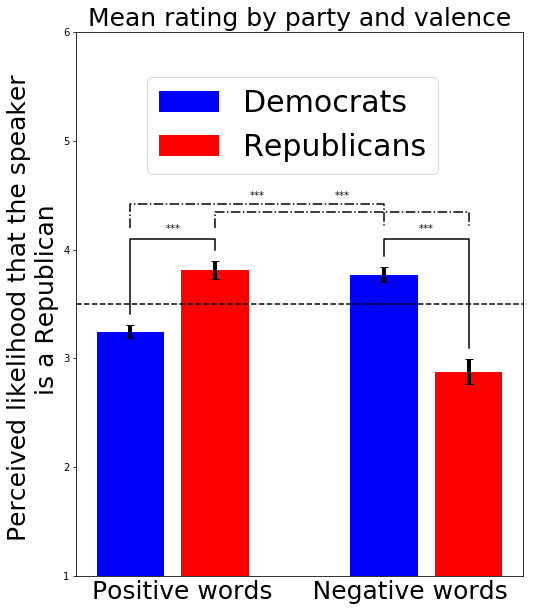

In [22]:
plt.figure(figsize = (8, 10))
mus = np.array([ d_pos_mu, r_pos_mu, d_neg_mu, r_neg_mu ])
sigs = np.array([ se_dp, se_rp, se_dn, se_rn ])
bax = plt.bar([ 1, 2, 4, 5 ], mus, 
              color = [ "blue", "red", "blue", "red" ], 
              yerr = sigs, error_kw = {"linewidth": 4,
              "capsize":4})
plt.ylim([1,6])
xlim = plt.xlim()
plt.xlim(*xlim)
plt.xticks([])
plt.xlabel("Positive words     Negative words", fontsize = 25)
plt.plot(xlim, [3.5, 3.5], "k--")
plt.title("Mean rating by party and valence", fontsize = 25)
heights = mus + sigs
inc = .1
star_height = max(heights) + .2

# Difference between Republicans and Democrats' judgments on the positive words
plt.plot([ 1,1,2,2 ], [ heights[0] + inc, star_height, 
                        star_height, heights[1] + inc],
         linewidth = 1.5, color = "k")
plt.text(1.5, star_height + .05, "***", ha = "center", va = "bottom",
         color = "k")

# Difference between Republicans and Democrats' judgments on the negative words
plt.plot([ 4,4,5,5 ], [ heights[2] + inc, star_height, 
                        star_height, heights[3] + inc],
         linewidth = 1.5, color = "k")
plt.text(4.5, star_height + .05, "***", ha = "center", va = "bottom",
         color = "k")

# Difference between Democrats' judgments on the positive and negative words
plt.plot([ 1,1,4,4 ], [ star_height + .1, star_height + .32,
                        star_height + .32, star_height + .1],
         linestyle = "-.", linewidth = 1.5, color = "k")
plt.text(2.5, star_height + .35, "***", ha = "center", va = "bottom",
         color = "k")

# Difference between Republicans' judgments on the positive and negative words
plt.plot([ 2,2,5,5 ], [ star_height + .1, star_height + .25,
                        star_height + .25, star_height + .1],
         linestyle = "-.", linewidth = 1.5, color = "k")
plt.text(3.5, star_height + .35, "***", ha = "center", va = "bottom",
         color = "k")

plt.legend(bax, ("Democrats", "Republicans"), fontsize=30, loc="center", bbox_to_anchor=(.5, .75),#bbox_to_anchor=(.75, .75),
           bbox_transform=plt.gcf().transFigure, ncol=1)
plt.ylabel("Perceived likelihood that the speaker \n is a Republican", fontsize = 25)